# Test Affinity and comp w/ Miscibility Gap on Feldspar Ternary
- this algorithm is usually fast and accurate
- but it can fail to converge, causing major problems


In [1]:
import numpy as np
from os import path
import pandas as pd
import scipy.optimize as opt
from scipy import optimize
import scipy.linalg as lin
import scipy as sp
import sys
import sympy as sym

from collections import OrderedDict as odict

import matplotlib.pyplot as plt

import sunkenhull as hull
from thermoengine.model import GeoCompDB, SysComp

from scipy.spatial import ConvexHull
import scipy.interpolate as interp

import ternary

Required ENKI modules (ignore the error message from Rubicon running under Python 3.6+)

In [2]:
from thermoengine import coder, core, phases, model, equilibrate

In [3]:
modelDB = model.Database(database='Berman')

## Test miscibility gap for Feldspar

In [4]:
Fsp = modelDB.get_phase('Fsp')

## P/T conditions relevant to coexisting feldspars

In [5]:
T = 900+273
P = 8e3

In [6]:
Fsp.endmember_names

array(['albite', 'anorthite', 'sanidine'], dtype='<U9')

## Manually determine unmixing pair

In [7]:
def eval_pseudo_binary(f_Ab_kspar, nmol_bulk, TOL=3e-3):
    N = np.ceil(1/TOL).astype(int)
    nmol_kspar = np.array([f_Ab_kspar*nmol_bulk[0], 0, nmol_bulk[2]])
    nmol_plag  = np.array([(1-f_Ab_kspar)*nmol_bulk[0], nmol_bulk[1], 0])
    
    # print(nmol_kspar + nmol_plag - nmol_bulk)
    Y_kspar_bulk = nmol_kspar.sum()/(nmol_kspar.sum()+nmol_plag.sum())
    
    # Normalize pseudo-binary endmembers, critical step!!
    nmol_kspar /= nmol_kspar.sum()
    nmol_plag /= nmol_plag.sum()
    
    
    Y_kspar = np.linspace(0,1,N)
    nmol_binary = Y_kspar[:,np.newaxis]*nmol_kspar+(1-Y_kspar[:,np.newaxis])*nmol_plag
    G_binary = Fsp.gibbs_energy(np.full(N,T), np.full(N,P), mol=nmol_binary)
    G_endmems = G_binary[[0,-1]]
    G_ideal = G_endmems[0]*(1-Y_kspar) + G_endmems[1]*Y_kspar
    
    G_xs = G_binary-G_ideal
    
    
    return Y_kspar, G_xs, Y_kspar_bulk, nmol_binary, G_endmems

def get_binary_hull(Y_kspar, G_xs, fac_max=1e2):
    G_range = np.max(G_xs)-np.min(G_xs)
    G_max = G_range*1e2
    
    pts0 = np.vstack((Y_kspar, G_xs)).T
    pts = np.vstack((pts0, [0.5,G_max]))
    hull = ConvexHull(pts)
    ind_hull = hull.vertices
    ind_hull = np.sort(ind_hull)[:-1]
    
    fun_hull_xs = interp.interp1d(Y_kspar[ind_hull], G_xs[ind_hull], kind='linear')
    
    return fun_hull_xs, ind_hull

def eval_gibbs_misc_gap(logitf_Ab_kspar, nmol_bulk, TOL=3e-3):
    f_Ab_kspar = 1/(1+np.exp(-logitf_Ab_kspar))
    Y_kspar, G_xs, Y_kspar_bulk, nmol_binary, G_endmems = eval_pseudo_binary(
        f_Ab_kspar, nmol_bulk, TOL=TOL)
    try:
        fun_hull_xs, ind_hull = get_binary_hull(Y_kspar, G_xs)
        Y_gap_edges, G_gap_edges = refine_misc_gap_edges(Y_kspar, G_xs, ind_hull)

        endmem_num = Fsp.endmember_num
        mu_phs_endmem = Fsp.gibbs_energy(np.full(endmem_num,T), np.full(endmem_num,P), 
                                         mol=np.eye(endmem_num))
        #print(np.dot(mu_phs_endmem,nmol_binary[0]))
        #print(G_endmems[0])
        Gex_endmem0 = G_endmems[0]-np.dot(mu_phs_endmem,nmol_binary[0])
        Gex_endmem1 = G_endmems[1]-np.dot(mu_phs_endmem,nmol_binary[-1])
        
        #fun_binary = (lambda Y, G_endmems=G_endmems, fun_hull_xs=fun_hull_xs: 
        #              fun_hull_xs(Y) + Gex_endmem0*(1-Y) + Gex_endmem1*Y)
    
        #G_bulk = fun_binary(f_Ab_kspar)
        
        
        gap_frac = (Y_kspar_bulk-Y_gap_edges[0])/np.diff(Y_gap_edges)

        G_bulk_xs = np.dot(G_gap_edges, np.hstack((1-gap_frac, gap_frac))) 
        G_bulk = G_bulk_xs + Y_kspar_bulk*Gex_endmem1 + (1-Y_kspar_bulk)*Gex_endmem0
        
    except:
        G_bulk = np.inf
    return G_bulk

In [8]:
def refine_misc_gap_edges(Y_kspar, G_xs, ind_hull, YTOL=1e-7, resfac=3, keyboard=False):
    if keyboard:
        from IPython import embed; embed()

    dYres = Y_kspar[1]-Y_kspar[0]

    f_xs = interp.interp1d(Y_kspar, G_xs, kind='cubic')
    ind_hull_gap = np.where(np.diff(ind_hull)>1)[0][0]
    ind_gap_edges = ind_hull[[ind_hull_gap, ind_hull_gap+1]]
    # nmol_gap_edges = nmol_binary[ind_gap_edges]
    G_gap_edges = G_xs[ind_gap_edges]
    Y_gap_edges = Y_kspar[ind_gap_edges]


    while True:
        dGdY = np.diff(G_gap_edges)/np.diff(Y_gap_edges)
        mu_bin1 = G_gap_edges[0] - dGdY*Y_gap_edges[0]
        mu_bin2 = G_gap_edges[1] + dGdY*(1-Y_gap_edges[1])

        df_xs = lambda Y, mu_bin1=mu_bin1, mu_bin2=mu_bin2: (
            f_xs(Y)-(Y*mu_bin2+(1-Y)*mu_bin1) )

        bnds1 = Y_gap_edges[0]+resfac*dYres*np.array([-1,+1])
        bnds2 = Y_gap_edges[1]+resfac*dYres*np.array([-1,+1])

        output1 = optimize.minimize_scalar(df_xs,  method='bounded',bounds=bnds1)
        output2 = optimize.minimize_scalar(df_xs,  method='bounded',bounds=bnds2)


        dG_gap_edges = np.array([output1['fun'], output2['fun']]).squeeze()
        G_gap_edges += dG_gap_edges
        Y_gap_edges_new = np.array([output1['x'], output2['x']]).squeeze()
        dY_gap_edges = Y_gap_edges_new-Y_gap_edges
        Y_gap_edges = Y_gap_edges_new

        #print(dG_gap_edges)
        #print(dY_gap_edges)
        if np.all(  np.abs(dY_gap_edges)<YTOL):
            break

    return Y_gap_edges, G_gap_edges

In [9]:
# itieline = get_misc_gap_edges(f_Ab_kspar_min, nmol_bulk, TOL=TOL,keyboard=True)

In [10]:

nmol_bulk = np.array([.33,.33,.33])

f_Ab_kspar0 = 0.9

In [11]:

Y_kspar, G_xs, Y_kspar_bulk, nmol_binary, G_endmems = eval_pseudo_binary(
    f_Ab_kspar0, nmol_bulk, TOL=3e-3)


fun_hull_xs, ind_hull = get_binary_hull(Y_kspar, G_xs)
Y_gap_edges, G_gap_edges = refine_misc_gap_edges(Y_kspar, G_xs, ind_hull)


endmem_num = Fsp.endmember_num
mu_phs_endmem = Fsp.gibbs_energy(np.full(endmem_num,T), np.full(endmem_num,P), 
                                         mol=np.eye(endmem_num))
#print(np.dot(mu_phs_endmem,nmol_binary[0]))
#print(G_endmems[0])
Gex_endmem0 = G_endmems[0]-np.dot(mu_phs_endmem,nmol_binary[0])
Gex_endmem1 = G_endmems[1]-np.dot(mu_phs_endmem,nmol_binary[-1])

# fun_binary = (lambda Y, G_endmems=G_endmems, fun_hull_xs=fun_hull_xs: 
#               fun_hull_xs(Y) + Gex_endmem0*(1-Y) + Gex_endmem1*Y)

# G_bulk = fun_binary(f_Ab_kspar0)

gap_frac = (Y_kspar_bulk-Y_gap_edges[0])/np.diff(Y_gap_edges)

G_bulk_xs = np.dot(G_gap_edges, np.hstack((1-gap_frac, gap_frac))) 
G_bulk = G_bulk_xs + Y_kspar_bulk*Gex_endmem1 + (1-Y_kspar_bulk)*Gex_endmem0




In [12]:
G_bulk

-4216.124731346712

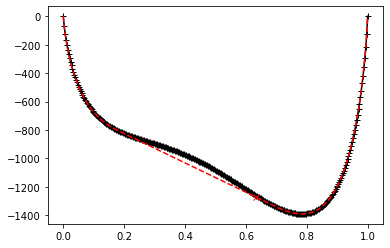

In [13]:
plt.figure()
#plt.plot(Y_kspar, G_binary,'ko-')
#plt.plot(Y_kspar, G_ideal, 'r--')
plt.plot(Y_kspar, G_xs, 'k+-')
plt.plot(Y_kspar,fun_hull_xs(Y_kspar), 'r--')
plt.plot(Y_kspar_bulk,fun_hull_xs(Y_kspar_bulk), 'rx')
#plt.plot([0,1],[mu_bin1,mu_bin2],'b:')

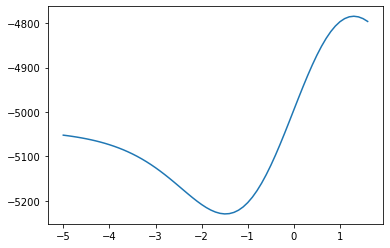

In [14]:
#nmol_bulk = np.array([.33,.33,.33])
nmol_bulk = np.array([.6,.1,.3])
nmol_bulk = np.array([.6,.35,.05])
nmol_bulk = np.array([.4,.3,.3])
#nmol_bulk = np.array([.4,.1,.5])
# nmol_bulk = np.array([.4,.05,.55])

logitf_Ab_kspar_grid = np.linspace(-5,+5,101)
G_bulk_ties = np.array([eval_gibbs_misc_gap(logitf, nmol_bulk) 
                        for logitf in logitf_Ab_kspar_grid])

plt.figure()
plt.plot(logitf_Ab_kspar_grid, G_bulk_ties,'-')

In [15]:
#output = optimize.minimize_scalar(eval_gibbs_misc_gap, bounds=[0.0,1.0], 
#                                  method='bounded', args=(nmol_bulk))

output = optimize.minimize_scalar(eval_gibbs_misc_gap, 
                                  method='brent', args=(nmol_bulk))
output
logitf_Ab_kspar_min = output['x']
f_Ab_kspar_min = 1/(1+np.exp(-logitf_Ab_kspar_min))
print(f_Ab_kspar_min)
print(logitf_Ab_kspar_min)

0.1849147142088734
-1.4833980384016046


In [16]:
def get_misc_gap_edges(f_Ab_kspar, nmol_bulk, TOL=3e-3, keyboard=False):
    Y_kspar, G_xs, Y_kspar_bulk, nmol_binary, G_endmems = eval_pseudo_binary(
        f_Ab_kspar, nmol_bulk, TOL=TOL)
    fun_hull_xs, ind_hull = get_binary_hull(Y_kspar, G_xs)
    
      
    
    try:
        
        Y_gap_edges, G_gap_edges = refine_misc_gap_edges(Y_kspar, G_xs, ind_hull, 
                                                         keyboard=keyboard)
        
        # print('Y_gap_edges = ', Y_gap_edges)
        # ind_hull_gap = np.where(np.diff(ind_hull)>1)[0][0]
        # ind_gap_edges = ind_hull[[ind_hull_gap, ind_hull_gap+1]]
        # nmol_gap_edges = nmol_binary[ind_gap_edges]
        nmol_gap_edges = np.vstack(
            (Y_gap_edges[0]*nmol_binary[-1]+(1-Y_gap_edges[0])*nmol_binary[0],
             Y_gap_edges[1]*nmol_binary[-1]+(1-Y_gap_edges[1])*nmol_binary[0]))
    except:
        nmol_gap_edges = np.tile(np.nan, (3,2))
        
    plot_edges = 100*nmol_gap_edges[:,::-1]
    
    tieline = {}
    tieline['Y_kspar'] = Y_kspar
    tieline['G_xs'] = G_xs
    tieline['Y_kspar_bulk'] = Y_kspar_bulk
    tieline['fun_hull_xs'] = fun_hull_xs
    tieline['mol_edges'] = nmol_gap_edges
    tieline['plot_edges'] = plot_edges
    return tieline

## Validate that miscibility gap edges have same chem potential
- test currently fails regardless of tol settings
- hull alone is not enough to get convergence

In [17]:
nmol_bulk = np.array([.2,.4,.4])
nmol_bulk = np.array([.4,.05,.55])
nAb = .5
kspar_split = .5

nmol_bulk = np.array([nAb, (1-kspar_split)*(1-nAb),kspar_split*(1-nAb)])

TOL=1e-3
XTOL = 1e-10
#xatol=1e-5
#output = optimize.minimize_scalar(eval_gibbs_misc_gap, bounds=[1e-4,1.0-1e-4], 
#                                   method='bounded', args=(nmol_bulk, TOL),
#                                   options={'xatol': xatol})

output = optimize.minimize_scalar(eval_gibbs_misc_gap, 
                                  method='brent', args=(nmol_bulk, TOL), options={'xtol':XTOL})

print(output)
logitf_Ab_kspar_min = output['x']

f_Ab_kspar_min = 1/(1+np.exp(-logitf_Ab_kspar_min))
print(f_Ab_kspar_min)
itieline = get_misc_gap_edges(f_Ab_kspar_min, nmol_bulk, TOL=TOL,keyboard=False)
mol_edges = itieline['mol_edges']
print(mol_edges)

/Users/aswolf/anaconda/envs/py37/lib/python3.7/site-packages/scipy/optimize/optimize.py:2522: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


     fun: -5488.415294300545
    nfev: 25
     nit: 20
 success: True
       x: -1.6684365514383976
0.1586327384587501
[[0.57311386 0.32053281 0.10635332]
 [0.28046935 0.03821919 0.68131146]]


In [18]:
mu_1 = Fsp.chem_potential(T, P, mol=mol_edges[0]).squeeze()
mu_2 = Fsp.chem_potential(T, P, mol=mol_edges[1]).squeeze()
mu_1-mu_2


array([ 0.04018308, -0.14989748,  0.02570607])

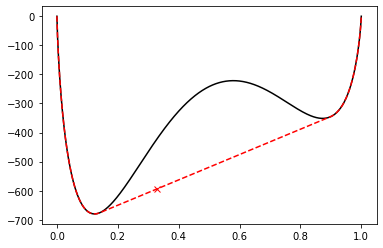

In [19]:
plt.figure()
#plt.plot(Y_kspar, G_binary,'ko-')
#plt.plot(Y_kspar, G_ideal, 'r--')
plt.plot(itieline['Y_kspar'], itieline['G_xs'], 'k-')
plt.plot(itieline['Y_kspar'],itieline['fun_hull_xs'](itieline['Y_kspar']), 'r--')
plt.plot(itieline['Y_kspar_bulk'],itieline['fun_hull_xs'](itieline['Y_kspar_bulk']), 'rx')

In [20]:
# itieline

In [21]:
tieline_edge_kspar = []
tieline_edge_plag = []
X_plag = []
X_kspar = []
tieline_data = []
dmu_edges = []
muavg_edges = []

TOL = 3e-3
# xatol=1e-5

nmol_Ab = np.linspace(1e-2,.99, 31)

for inmol_Ab in nmol_Ab:
    kspar_split = .8
    ielse = (1-inmol_Ab)
    inmol_bulk = np.array([inmol_Ab,ielse*(1-kspar_split),ielse*kspar_split])
    print(inmol_bulk)


    ioutput = optimize.minimize_scalar(eval_gibbs_misc_gap, 
                                      method='brent', args=(inmol_bulk, TOL))
    #ioutput = optimize.minimize_scalar(eval_gibbs_misc_gap, bounds=[0.0,1.0], 
    #                                   method='bounded', args=(inmol_bulk, TOL),
    #                                   options={'xatol': xatol})

    logitf_Ab_kspar_min = ioutput['x']
    f_Ab_kspar_min = 1/(1+np.exp(-logitf_Ab_kspar_min))
    #print(f_Ab_kspar_min)
    itieline = get_misc_gap_edges(f_Ab_kspar_min, inmol_bulk, TOL=TOL)
    imu1 = Fsp.chem_potential(T, P, mol=itieline['mol_edges'][0]).squeeze()
    imu2 = Fsp.chem_potential(T, P, mol=itieline['mol_edges'][1]).squeeze()
    
    dmu_edges.append(imu1-imu2)
    muavg_edges.append(0.5*(imu1+imu2))
    
    tieline_data.append(itieline)

    tieline_edge_plag.append(itieline['plot_edges'][0])
    tieline_edge_kspar.append(itieline['plot_edges'][1])
    X_plag.append(itieline['mol_edges'][0])
    X_kspar.append(itieline['mol_edges'][1])
    
tieline_edge_plag = np.array(tieline_edge_plag)
tieline_edge_kspar = np.array(tieline_edge_kspar)
#X_plag = np.vstack(X_plag)
#X_kspar = np.vstack(X_kspar)
dmu_edges = np.array(dmu_edges)
muavg_edges = np.array(muavg_edges)

[0.01  0.198 0.792]
[0.04266667 0.19146667 0.76586667]
[0.07533333 0.18493333 0.73973333]
[0.108  0.1784 0.7136]
[0.14066667 0.17186667 0.68746667]
[0.17333333 0.16533333 0.66133333]
[0.206  0.1588 0.6352]
[0.23866667 0.15226667 0.60906667]
[0.27133333 0.14573333 0.58293333]
[0.304  0.1392 0.5568]
[0.33666667 0.13266667 0.53066667]
[0.36933333 0.12613333 0.50453333]
[0.402  0.1196 0.4784]
[0.43466667 0.11306667 0.45226667]
[0.46733333 0.10653333 0.42613333]
[0.5 0.1 0.4]
[0.53266667 0.09346667 0.37386667]
[0.56533333 0.08693333 0.34773333]
[0.598  0.0804 0.3216]
[0.63066667 0.07386667 0.29546667]
[0.66333333 0.06733333 0.26933333]
[0.696  0.0608 0.2432]
[0.72866667 0.05426667 0.21706667]
[0.76133333 0.04773333 0.19093333]
[0.794  0.0412 0.1648]
[0.82666667 0.03466667 0.13866667]
[0.85933333 0.02813333 0.11253333]
[0.892  0.0216 0.0864]
[0.92466667 0.01506667 0.06026667]
[0.95733333 0.00853333 0.03413333]
[0.99  0.002 0.008]


In [22]:
X_plag[7]

array([0.4110135 , 0.52524265, 0.06374385])

No handles with labels found to put in legend.


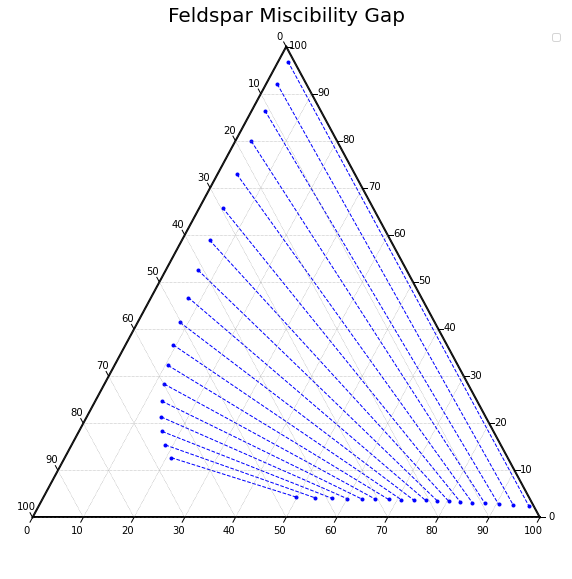

In [23]:
scale = 100
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(10, 10)
# Plot a few different styles with a legend
# points = random_points(30, scale=scale)
#tax.scatter(100*tieline['mol_edges'], marker='s', color='red', label="Red Squares")

for i in range(tieline_edge_plag.shape[0]):
    tax.line(tieline_edge_plag[i],
             tieline_edge_kspar[i], 
             linewidth=1., marker='o', color='blue', linestyle="--",ms=3)
    
#points = random_points(30, scale=scale)
#tax.scatter(points, marker='D', color='green', label="Green Diamonds")
tax.legend()
tax.set_title("Feldspar Miscibility Gap", fontsize=20)
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=10, color="gray")
tax.ticks(axis='lbr', linewidth=1, multiple=10)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.show()

## Validate affinity_and_comp on tieline edges
- show we can recover both ends of tieline
- comp agree to within 1e-4 moles

In [24]:
ind=3
imu = muavg_edges[ind]
iX_plag = X_plag[ind]
iX_kspar = X_kspar[ind]

#iX_plag /= iX_plag.sum()
#iX_kspar /= iX_kspar.sum()

In [25]:
Fsp.affinity_and_comp(T, P, imu)

(0.03400174386555824, array([0.16923642, 0.79920374, 0.03155985]))

In [26]:
A_kspar, nmol_kspar = Fsp.affinity_and_comp(T, P, imu, X_init=[0,0,1])
A_plag, nmol_plag = Fsp.affinity_and_comp(T, P, imu, X_init=[0,1,0])

In [27]:
nmol_kspar-iX_kspar

array([-1.89613035e-05, -1.56401101e-05,  3.46014136e-05])

In [28]:
nmol_plag-iX_plag

array([-6.52472789e-05,  9.02030342e-05, -2.49557553e-05])